In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib


In [23]:
# Load the Excel file
file_path = 'Rotten_Tomatoes_Movies3.xls'  # Update the path as needed
df = pd.read_excel(file_path)

# Step 1: Drop rows with missing target (audience_rating)
df_clean = df.dropna(subset=['audience_rating'])

# Step 2: Drop irrelevant columns (movie_title, on_streaming_date, in_theaters_date)
columns_to_drop = ['movie_title', 'on_streaming_date', 'in_theaters_date']
df_clean = df_clean.drop(columns=columns_to_drop)

# Step 3: Identify categorical and numerical columns
categorical_features = df_clean.select_dtypes(include=['object', 'category']).columns
numerical_features = df_clean.select_dtypes(include=['int64', 'float64']).columns

# Exclude target from numerical features
numerical_features = numerical_features.drop('audience_rating')

# Step 4: Handle missing values for categorical and numerical features
df_clean[categorical_features] = df_clean[categorical_features].fillna('unknown')
df_clean[numerical_features] = df_clean[numerical_features].fillna(df_clean[numerical_features].mean())

# Check data information
print(df_clean.info())


<class 'pandas.core.frame.DataFrame'>
Index: 16386 entries, 0 to 16637
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie_info          16386 non-null  object 
 1   critics_consensus   16386 non-null  object 
 2   rating              16386 non-null  object 
 3   genre               16386 non-null  object 
 4   directors           16386 non-null  object 
 5   writers             16386 non-null  object 
 6   cast                16386 non-null  object 
 7   runtime_in_minutes  16386 non-null  float64
 8   studio_name         16386 non-null  object 
 9   tomatometer_status  16386 non-null  object 
 10  tomatometer_rating  16386 non-null  int64  
 11  tomatometer_count   16386 non-null  int64  
 12  audience_rating     16386 non-null  float64
dtypes: float64(2), int64(2), object(9)
memory usage: 1.8+ MB
None


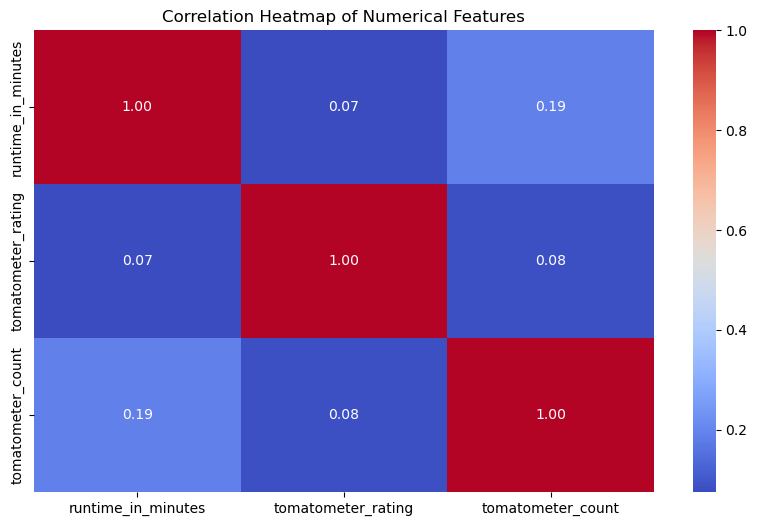

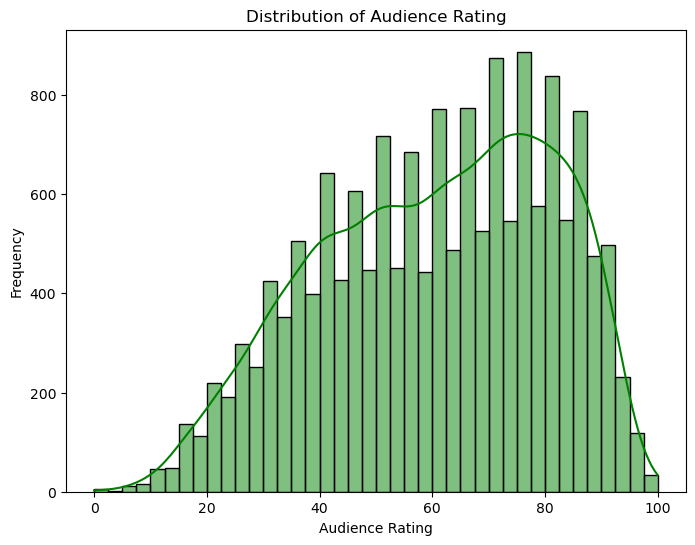

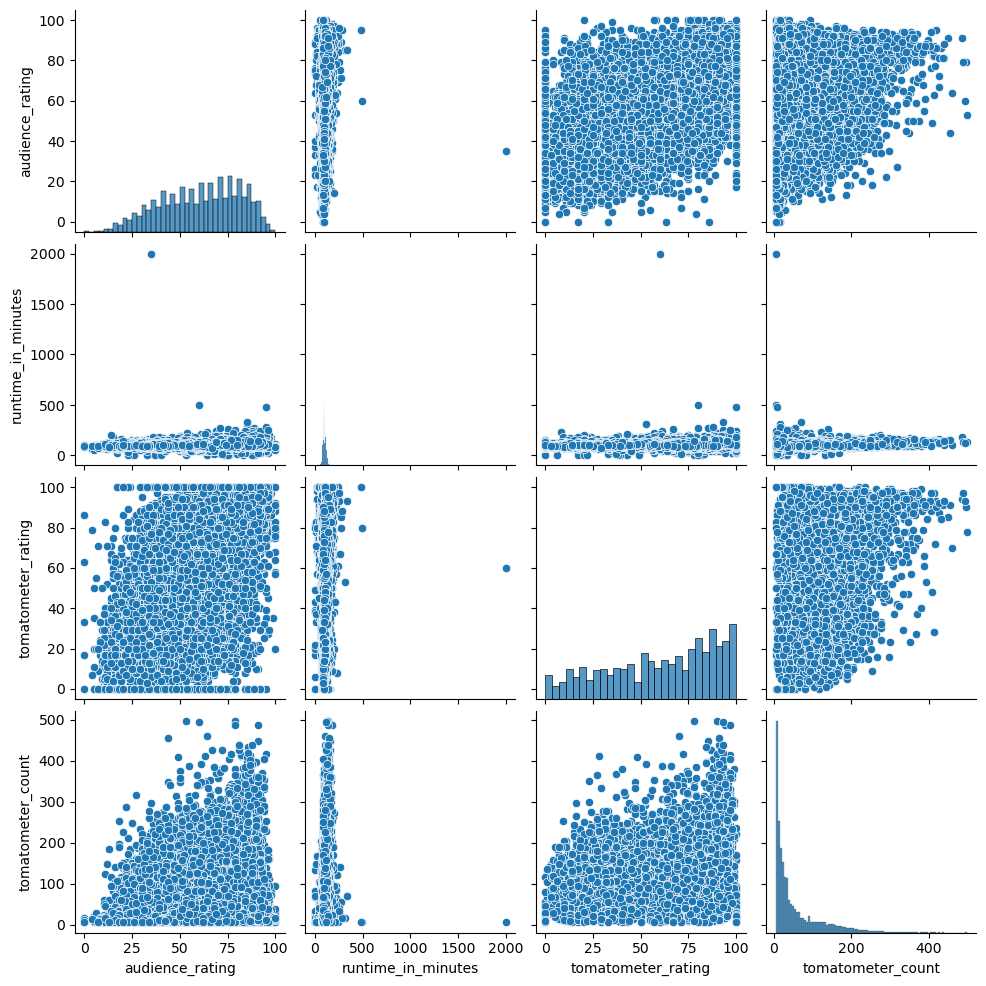

In [25]:
# Correlation heatmap for numerical features
plt.figure(figsize=(10, 6))
sns.heatmap(df_clean[numerical_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

# Distribution of the target variable (audience_rating)
plt.figure(figsize=(8, 6))
sns.histplot(df_clean['audience_rating'], kde=True, color='green')
plt.title('Distribution of Audience Rating')
plt.xlabel('Audience Rating')
plt.ylabel('Frequency')
plt.show()

# Pairplot to visualize relationships between key numerical features and audience_rating
sns.pairplot(df_clean[['audience_rating', 'runtime_in_minutes', 'tomatometer_rating', 'tomatometer_count']])
plt.show()


In [27]:
# Separate features (X) and target (y)
X = df_clean.drop(columns=['audience_rating'])
y = df_clean['audience_rating']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Testing set: {X_test.shape}, {y_test.shape}")


Training set: (13108, 12), (13108,)
Testing set: (3278, 12), (3278,)


In [29]:
# Handle missing values and scaling for numerical data
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Handle missing values and encoding for categorical data
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_features),
        ('cat', cat_transformer, categorical_features)
    ]
)


In [31]:
# Create the model pipeline with RandomForestRegressor
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train the model
model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['runtime_in_minutes', 'tomatometer_rating', 'tomatometer_count'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['movie_info', 'critics_consensus', 'rating', 'genre', 'directors',
       'writers', 'cast', 'studio_name', 'tomatometer_status'],
      dtype='object'))])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [33]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")


Mean Squared Error (MSE): 216.1918817876754
Mean Absolute Error (MAE): 11.429374618669922
R-squared (R2): 0.47617159845245516


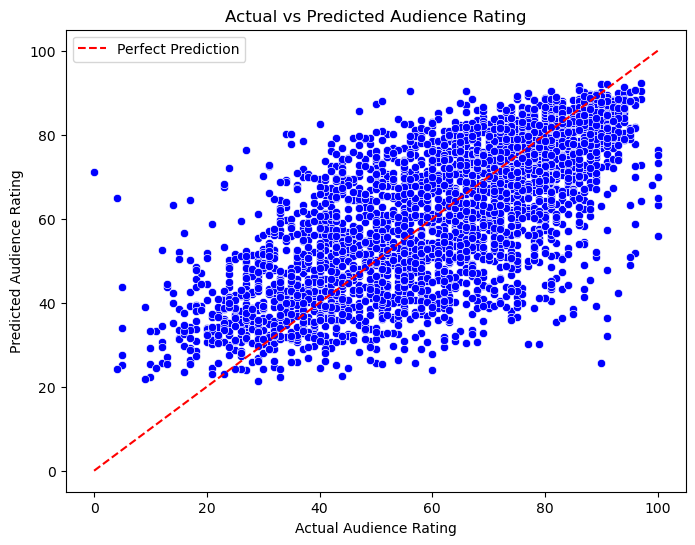

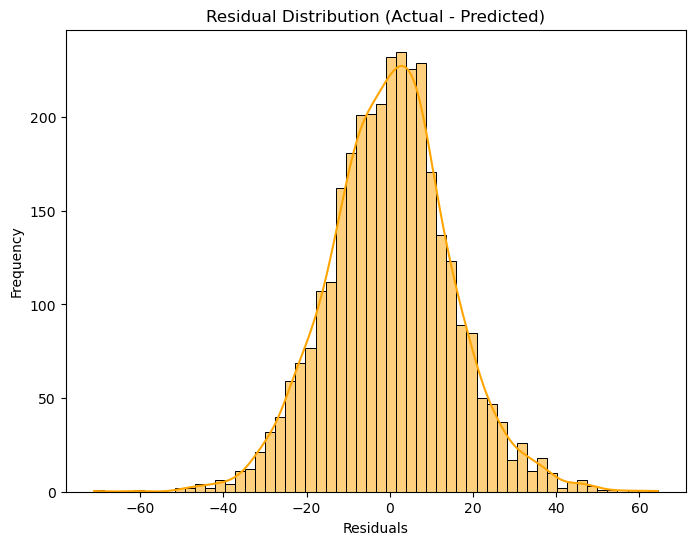

In [35]:
# Plot the actual vs predicted values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Audience Rating')
plt.ylabel('Predicted Audience Rating')
plt.title('Actual vs Predicted Audience Rating')
plt.legend()
plt.show()

# Residual plot (difference between true and predicted values)
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='orange')
plt.title('Residual Distribution (Actual - Predicted)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

In [37]:
# Save the trained model to a file
joblib.dump(model, 'audience_rating_model.pkl')
print("Model saved successfully as 'audience_rating_model.pkl'")


Model saved successfully as 'audience_rating_model.pkl'


In [39]:
# Load the saved model
loaded_model = joblib.load('audience_rating_model.pkl')

# Predict for new data (using one row from X_test as an example)
new_data = pd.DataFrame([X_test.iloc[0]])  # Take one sample from the test set
new_prediction = loaded_model.predict(new_data)

print(f"New Prediction for sample input: {new_prediction}")


New Prediction for sample input: [62.68]
